# リポジトリクローン

In [1]:
!git clone https://github.com/devzwy/open_nsfw_android

Cloning into 'open_nsfw_android'...
remote: Enumerating objects: 2112, done.
remote: Counting objects: 100% (506/506), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 2112 (delta 193), reused 407 (delta 106), pack-reused 1606
Receiving objects: 100% (2112/2112), 150.25 MiB | 25.63 MiB/s, done.
Resolving deltas: 100% (667/667), done.


In [2]:
!cp open_nsfw_android/app/src/main/assets/nsfw.tflite ./

# 必要パッケージインストール

In [3]:
!pip install -U tf2onnx
!pip install onnxruntime
!pip install imread_from_url

     |████████████████████████████████| 435 kB 5.2 MB/s 
     |████████████████████████████████| 12.7 MB 44.4 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
     |████████████████████████████████| 4.8 MB 5.0 MB/s 
  Created wheel for imread-from-url: filename=imread_from_url-0.1.1-py3-none-any.whl size=6456 sha256=f14abf106e92e0dd2caf1fb0fadb218a57376e433e94b5c28388f52591fca380
  Stored in directory: /root/.cache/pip/wheels/ac/36/34/c633c8d8fc0b81b2579548e96877edd7679f6ab1895d2b1d23
Successfully built imread-from-url


# TensorFlow Lite推論確認

In [4]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

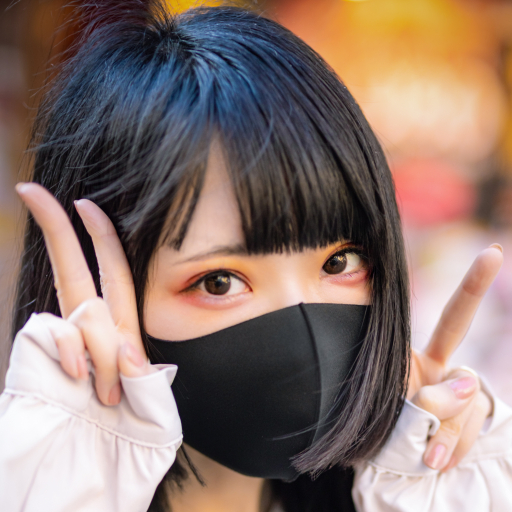

In [5]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [6]:
# モデルロード
import tensorflow as tf

interpreter = tf.lite.Interpreter('nsfw.tflite')
interpreter.allocate_tensors()

In [7]:
%%time 

import cv2 as cv
import numpy as np

# 前処理
x = cv.resize(image, dsize=(224, 224))
x = cv.cvtColor(x, cv.COLOR_BGR2RGB)

vgg_mean = [104, 117, 123]
x = x - vgg_mean

x = np.array(x, dtype=np.float32)
x = x.reshape(-1, 224, 224, 3)

# 推論
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], x)
interpreter.invoke()

output_details = interpreter.get_output_details()
result = interpreter.get_tensor(output_details[0]['index'])

# 後処理
result = np.squeeze(result).astype(np.float32)
print('sfw :', '{:.3f}'.format(result[0]))
print('nsfw:', '{:.3f}'.format(result[1]))

sfw : 0.995
nsfw: 0.005
CPU times: user 133 ms, sys: 27.9 ms, total: 161 ms
Wall time: 119 ms


# ONNX変換

In [8]:
!python -m tf2onnx.convert --opset 13 \
    --tflite nsfw.tflite \
    --output nsfw.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-12-06 15:48:23,894 - INFO - Using tensorflow=2.7.0, onnx=1.10.2, tf2onnx=1.9.3/1190aa
2021-12-06 15:48:23,894 - INFO - Using opset <onnx, 13>
2021-12-06 15:48:24,286 - INFO - Optimizing ONNX model
2021-12-06 15:48:25,460 - INFO - After optimization: Const -32 (142->110), Identity -1 (1->0), Transpose -216 (217->1)
2021-12-06 15:48:25,510 - INFO - 
2021-12-06 15:48:25,510 - INFO - Successfully converted TensorFlow model nsfw.tflite to ONNX
2021-12-06 15:48:25,510 - INFO - Model inputs: ['input']
2021-12-06 15:48:25,510 - INFO - Model outputs: ['predictions']
2021-12-06 15:48:25,510 - INFO - ONNX model is saved at nsfw.onnx


# ONNX推論確認

In [9]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

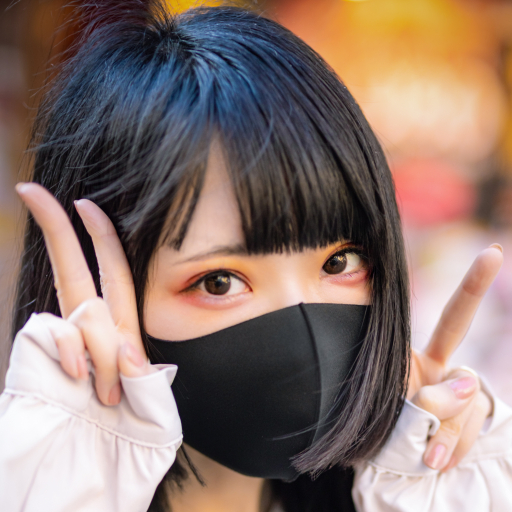

In [10]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [11]:
# モデルロード
import onnxruntime

onnx_session = onnxruntime.InferenceSession('nsfw.onnx')

In [12]:
%%time 

import cv2 as cv
import numpy as np

# 前処理
x = cv.resize(image, dsize=(224, 224))
x = cv.cvtColor(x, cv.COLOR_BGR2RGB)

vgg_mean = [104, 117, 123]
x = x - vgg_mean

x = np.array(x, dtype=np.float32)
x = x.reshape(-1, 224, 224, 3)

# 推論
input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name
result = onnx_session.run([output_name], {input_name: x})

# 後処理
result = np.squeeze(result).astype(np.float32)
print('sfw :', '{:.3f}'.format(result[0]))
print('nsfw:', '{:.3f}'.format(result[1]))

sfw : 0.999
nsfw: 0.001
CPU times: user 55.8 ms, sys: 3.12 ms, total: 58.9 ms
Wall time: 58.9 ms
